## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Притугин Михаил Алексеевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:06, 1452843.26it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 76902.74it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:03, 501100.77it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 30205.83it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

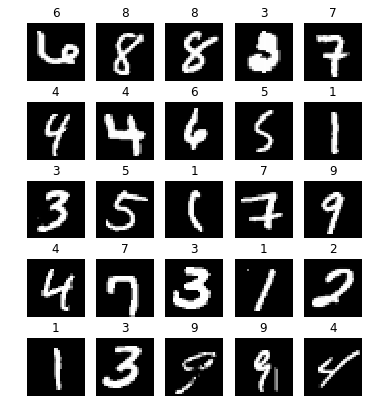

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [7]:
def new_linear_layer(input_size, output_size, mean, std):
    layer = nn.Linear(input_size, output_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, mean, std)
    return layer

In [18]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(0.1)))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(0.1)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(0.1)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)

In [19]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0152685642242432
forward 5.248520374298096
forward 27.82752799987793
forward 144.17066955566406
forward 707.1377563476562
forward 3394.614013671875
forward 15496.67578125
forward 75072.65625
forward 371930.53125
forward 1730018.0
forward 8802545.0
forward 40406784.0
backward 0.24935460090637207
backward 0.14599096775054932
backward 0.6652238965034485
backward 2.9445838928222656
backward 12.801406860351562
backward 57.89562225341797
backward 240.19822692871094
backward 1069.1898193359375
backward 4681.427734375
backward 20252.5078125
backward 95286.65625
backward 416613.3125


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [20]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./500)))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./500)))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./10)))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)

In [21]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0152685642242432
forward 1.0526559352874756
forward 1.0512545108795166
forward 1.0421664714813232
forward 1.056275486946106
forward 1.0288629531860352
forward 1.0986045598983765
forward 1.1145703792572021
forward 1.1859225034713745
forward 1.1947885751724243
forward 1.1444265842437744
forward 1.1037503480911255
backward 0.302989661693573
backward 0.26544883847236633
backward 0.2603287398815155
backward 0.2328118532896042
backward 0.2056346982717514
backward 0.19281485676765442
backward 0.17527882754802704
backward 0.1449001431465149
backward 0.1329842060804367
backward 0.11560935527086258
backward 0.0954827070236206
backward 0.07823770493268967


In [16]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./(784 + 500))))
layers.append(nn.ReLU())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./(500 + 500))))
    layers.append(nn.ReLU())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./(500 + 10))))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)

In [13]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0152685642242432
forward 0.6637521982192993
forward 0.48526081442832947
forward 0.337675005197525
forward 0.2397572547197342
forward 0.16662494838237762
forward 0.12225326150655746
forward 0.08672413975000381
forward 0.06322678923606873
forward 0.04449882358312607
forward 0.030659308657050133
forward 0.020866431295871735
backward 0.02776174433529377
backward 0.003997513093054295
backward 0.002752745058387518
backward 0.0020607076585292816
backward 0.0015372850466519594
backward 0.001087710727006197
backward 0.0008028352749533951
backward 0.0005679342430084944
backward 0.0004115042102057487
backward 0.00028828359791077673
backward 0.00019178149523213506
backward 0.000138255360070616


In [22]:
##### YOUR CODE HERE #####
layers = []
mean = 0
std = 0.1
layers.append(new_linear_layer(784, 500, mean=0, std=np.sqrt(2./(784 + 500))))
layers.append(nn.Tanh())
for i in range(10):
    layers.append(new_linear_layer(500, 500, mean=0, std=np.sqrt(2./(500 + 500))))
    layers.append(nn.Tanh())
layers.append(new_linear_layer(500, 10, mean=0, std=np.sqrt(2./(500 + 10))))
layers.append(nn.LogSoftmax())
network = nn.Sequential(*layers)

In [23]:
#пример:
n_objects = 100
X = Variable(images_train[:n_objects], requires_grad=False).view(n_objects, -1)
y = Variable(labels_train[:n_objects], requires_grad=False)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0152685642242432
forward 0.6583291292190552
forward 0.5018349885940552
forward 0.4167425036430359
forward 0.3636992871761322
forward 0.3216707408428192
forward 0.29784977436065674
forward 0.27380308508872986
forward 0.2571088373661041
forward 0.23929710686206818
forward 0.2287045568227768
forward 0.2198771983385086
backward 0.025652501732110977
backward 0.004457579925656319
backward 0.0041931080631911755
backward 0.0039878240786492825
backward 0.0038155238144099712
backward 0.003449066309258342
backward 0.0031799564603716135
backward 0.002897941740229726
backward 0.0025689706671983004
backward 0.0022258677054196596
backward 0.0019221333786845207
backward 0.0015080992598086596


<i> 1.4 Сделайте выводы по первой части </i>

# ReLU + He:

Затухает, но медленно - КУЛ

# ReLU + Xavier:

Затухает быстро - ФУУУУ

# Tanh + Xavier:

Затухает, но медленно - КУЛ

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [24]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 9... (Train/Test) NLL: 0.024/0.086	Accuracy: 0.992/0.975


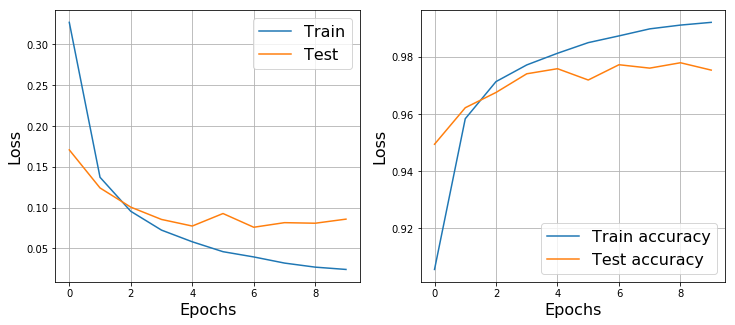

In [25]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

# Попробуем Linear -> Dropout -> ReLU

Epoch 9... (Train/Test) NLL: 0.202/0.225	Accuracy: 0.942/0.937


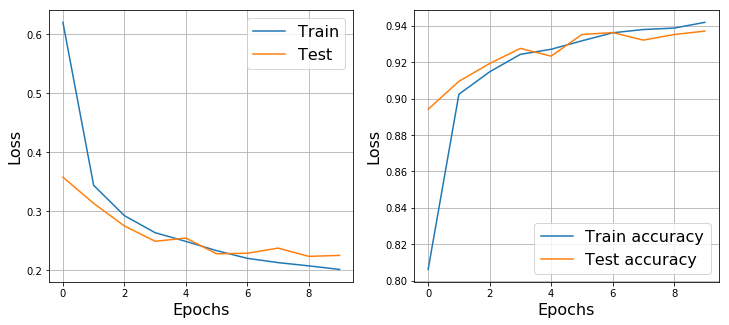

In [27]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

# Попробуем Linear -> ReLU -> Dropout

Epoch 9... (Train/Test) NLL: 0.204/0.241	Accuracy: 0.941/0.931


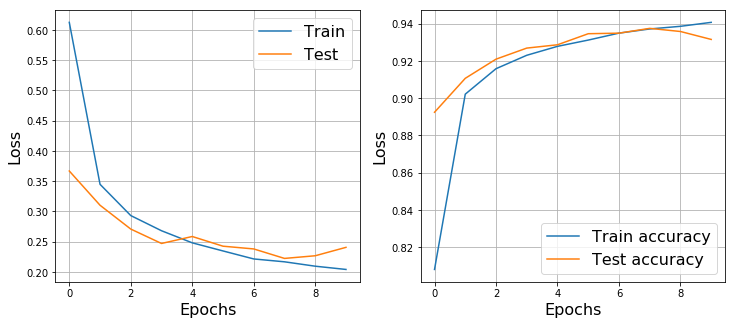

In [28]:
network = nn.Sequential(nn.Linear(784, 100),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

### ---------------------------

In [29]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std), requires_grad=True)
        self.bias = nn.Parameter(torch.Tensor(1, output_dim).zero_(), requires_grad=True)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros(self.weight.size())+self.p
            mask = torch.bernoulli(mask)
        else:
            mask = torch.ones(self.weight.size())*self.p
        mask = Variable(mask, requires_grad=False)
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

Epoch 9... (Train/Test) NLL: 0.120/0.124	Accuracy: 0.962/0.960


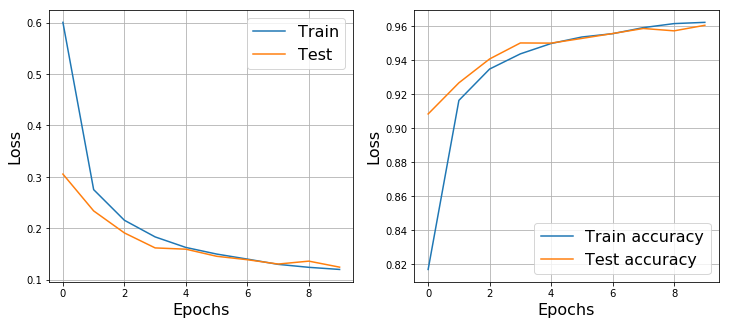

In [30]:
network = nn.Sequential(DropConnect(784, 100, p=0.5),
                        nn.ReLU(),
                        DropConnect(100, 100, p=0.5),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

Epoch 45... (Train/Test) NLL: 0.074/0.159	Accuracy: 0.977/0.961


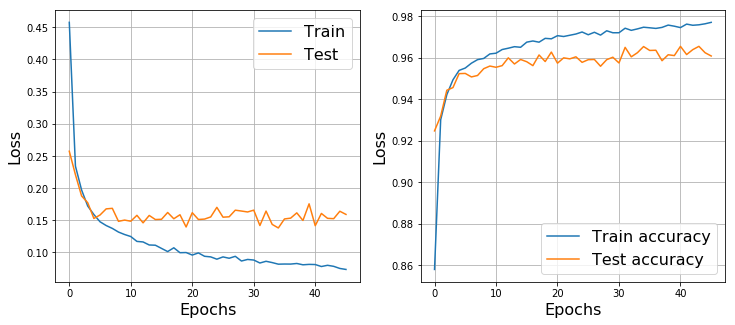

In [66]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 100, 0.001)

<i> 2.3 Сделайте выводы по третьей части </i>

# DropOut - Топ

# DropConnect - нахрен не нужен ведь есть DropOut

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [31]:
class LayerNormalization(nn.Module):
    def __init__(self, input_dim, init_gamma=0.1, init_beta=0.0):
        super().__init__()
        self.gamma = nn.Parameter(data=torch.empty(input_dim, dtype=torch.float32).fill_(init_gamma), requires_grad=True)
        self.beta = nn.Parameter(data=torch.empty(input_dim, dtype=torch.float32).fill_(init_beta), requires_grad=True)
    def forward(self, x):
        batch_size = x.shape[0]
        output = self.gamma * ((x - x.mean(dim=-1).reshape(batch_size, -1)) / x.std(dim=-1).reshape(batch_size, -1)) + self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.014/0.082	Accuracy: 0.995/0.977


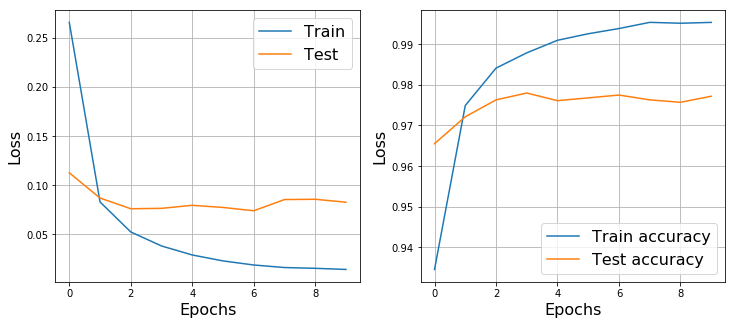

In [33]:
network = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.021/0.069	Accuracy: 0.993/0.980


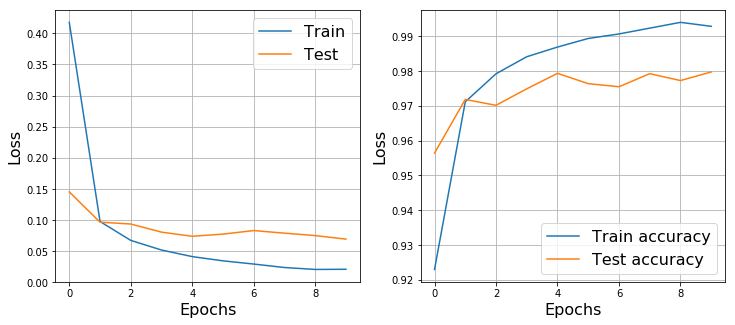

In [34]:
network = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, 10, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

Качество чуть улучшилось. Вообще штука полезная, т.к при нормализации данных слоям не надо адаптироваться под новые приходы с пред слоев, которые изменились в связи с тем что сеть обучается.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: